# Adaptive RAG with Pathway

This notebook shows how you can **dynamically adapt the number of documents in a RAG prompt** using feedback from the LLM. This can give you [significant cost reduction](https://pathway.com/developers/showcases/adaptive-rag) of RAG LLM question answering while maintaining good accuracy. 

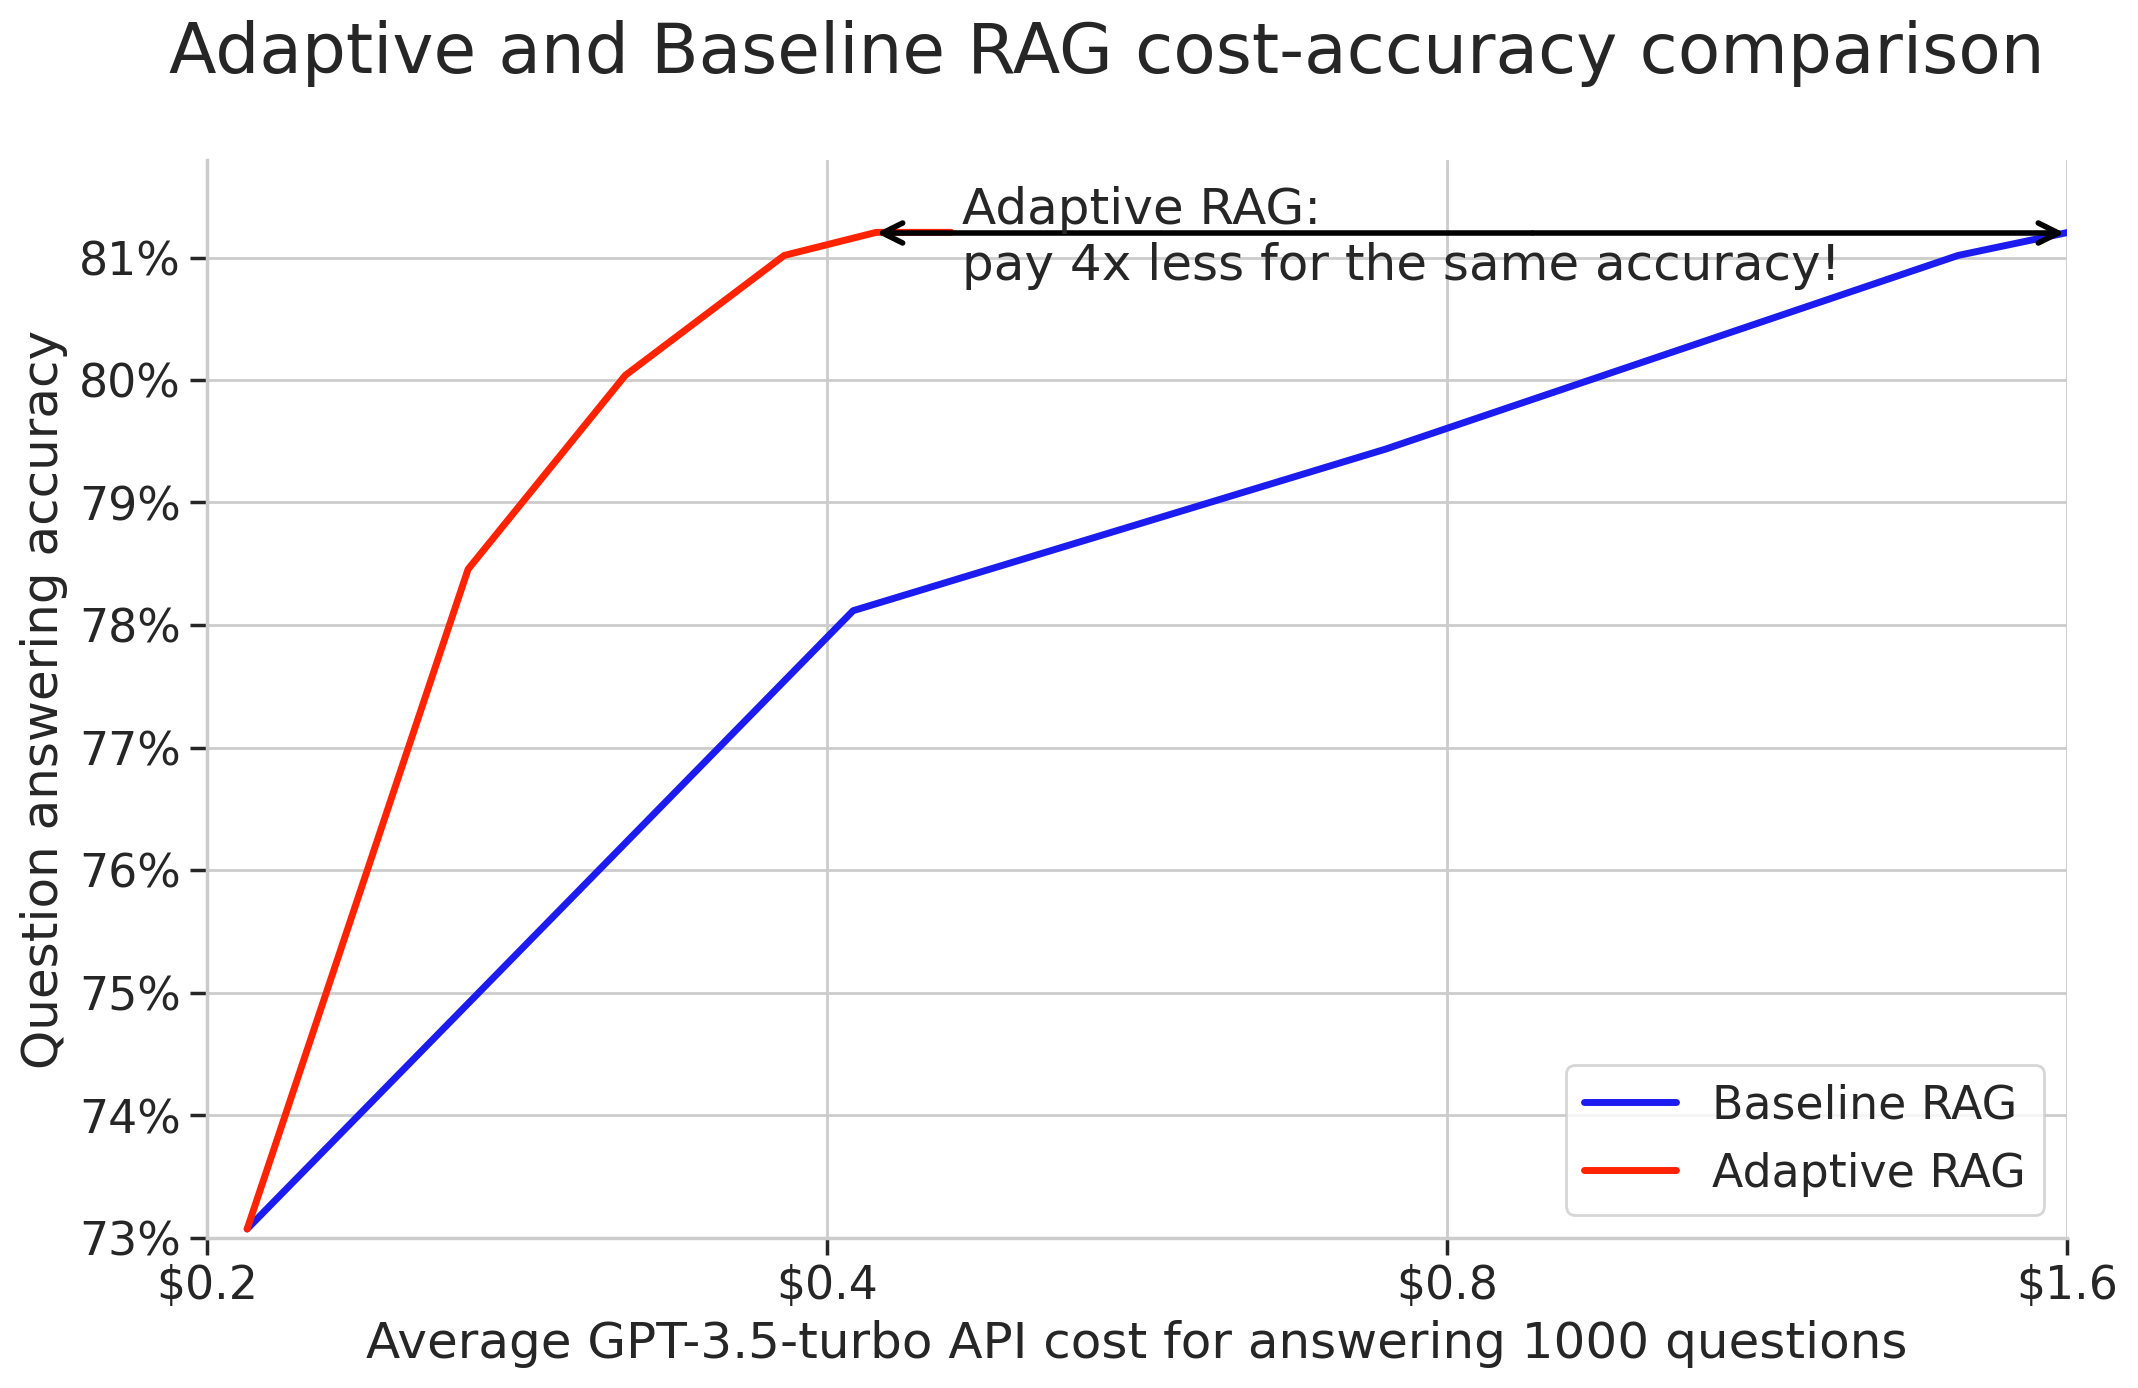


## Setup

### Using APIs 

* You will need a Mistral subscription to access the Mistral API.
* Create an account and fetch your API Key
* Pass the API Key into the prompt in this notebook or set it as environment variable `MISTRAL_API_KEY`

### Installing Libraries
You will need to have `pathway` and `mistralai` installed in your environment:

In [ ]:
# # Uncomment and run if you need to install Pathway and Mistral packages
# !pip install -U --prefer-binary pathway 
# !pip install "litellm>=1.35"

### Accessing Data
This notebook uses a sample JSON dataset with ~1000 context from the [SQUAD]() dataset. You can access it from the `data` directory or download it to your own machine using the code below. If you download it to another directory, make sure to update the path in the `documents = pw.io.fs.read(...)` call below.

In [ ]:
# # Download `adaptive-rag-contexts.jsonl` with ~1000 contexts from SQUAD dataset
# !wget -q -nc https://public-pathway-releases.s3.eu-central-1.amazonaws.com/data/adaptive-rag-contexts.jsonl

### Running locally
If you want to run this locally (e.g., on your laptop), use [Ollama](https://ollama.ai/library/mistral/tags):

* Download [Ollama app](https://ollama.ai/).
* Download a `Mistral` model e.g., `ollama pull mistral:instruct`, from various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral versions [here](https://ollama.ai/library/mixtral) available.
* Set flags indicating we will run locally and the Mistral model downloaded:

In [4]:
# # Flags for running locally
# run_local = "No"
# local_model = "ollama/mistral:instruct"

## Adaptive RAG Intuition

RAG question-answering applications involve an important trade-off regarding the context size. A large number of documents increases the ability of the LLM to provide a correct answer, but also increases LLM costs, which typically grow linearly with the length of the provided prompt. However, intuitively not all questions are equally hard and some can be answered using a small number of supporting documents, while some may require the LLM to consult a larger prompt. 

This is where **Adaptive RAG** comes in: 
1. start by asking the model to answer a question using a small number of documents.
2. If it refuses to answer, we will increase the context size.
3. We will do this iteratively until the model returns an answer. 

This improves the efficiency of our LLM pipeline. For most queries a single (cheap!) LLM call will be sufficient. A fraction of more complicated questions will require re-asking.

## Implementing Adaptive RAG

Let's implement Adaptive RAG by:
1. defining Mistral embedder and LLM
2. loading our context documents
3. defining our queries
4. running Adaptive RAG: to iteratively increase context size
5. inspecting the results

Start by importing the necessary libraries:

In [5]:
import getpass
import os

import pandas as pd

import pathway as pw
from pathway.stdlib.indexing import VectorDocumentIndex
from pathway.xpacks.llm.embedders import LiteLLMEmbedder, SentenceTransformerEmbedder 
from pathway.xpacks.llm.llms import LiteLLMChat  
from pathway.xpacks.llm.question_answering import (
    answer_with_geometric_rag_strategy_from_index,
)

Then define your Mistral embedder and LLM. If you want to run locally with Ollama, make sure to set the correct flags at the top of this notebook.

If you are not running locally and have not set the `MISTRAL_API_KEY` environment variable then the following cell will prompt you to securely pass your Mistral API Key.

*Note that for the local model:*
- we provide tested options for local embedders
- we specifically instruct the LLM to return json, which allows the LLM to follow the instructions more strictly.*

In [6]:
# Check API key
if run_local:
    pass
elif "MISTRAL_API_KEY" in os.environ:
    mistral_api_key = os.environ["MISTRAL_API_KEY"]
else:
    mistral_api_key = getpass.getpass("Mistral API Key:")

# Set config options
embedding_dimension: int = 1024

# choose embedder
large_model = "mixedbread-ai/mxbai-embed-large-v1"
medium_model = "avsolatorio/GIST-Embedding-v0"
small_model = "avsolatorio/GIST-small-Embedding-v0"

# define Mistral embedder
if run_local:
    embedder = SentenceTransformerEmbedder(small_model, call_kwargs={"show_progress_bar": False})  # disable verbose logs
else:
    embedder = LiteLLMEmbedder(
        capacity = 5, 
        retry_strategy = pw.udfs.FixedDelayRetryStrategy(),
        model = "mistral/mistral-embed",
        api_key=mistral_api_key,
    )

# define Mistral LLM
if run_local:
    model = LiteLLMChat(
        model=local_model, 
        temperature=0,
        top_p=1,
        format="json",  # only available in Ollama local deploy, not usable in Mistral API
    )
else:
    model = LiteLLMChat(
        model="mistral/mistral-large-latest", 
        temperature=0, 
        api_key=mistral_api_key,
        top_p=1
    )

Mistral API Key: ········


Next, let's load the context documents and create a table with our queries:

In [7]:
# Load documents in which answers will be searched
class InputSchema(pw.Schema):
    doc: str

documents = pw.io.fs.read(
    "data/adaptive-rag-contexts.jsonl",
    format="json",
    schema=InputSchema,
    json_field_paths={"doc": "/context"},
    mode="static",
)

# Create table with questions
df = pd.DataFrame(
    {
        "query": [
            "When it is burned what does hydrogen make?",
            #"When did Arnold switch from acting to politics?"
            "What was undertaken in 2010 to determine where dogs originated from?"
            #"What is a common nickname used to refer to dogs across multiple languages?",
        ]
    }
)
query = pw.debug.table_from_pandas(df)

Now let's create a Vector index of the documents and set up our Adaptive RAG:

In [8]:
# Index for finding closest documents
index = VectorDocumentIndex(
    documents.doc, documents, embedder, n_dimensions=embedding_dimension
)

# Run Adaptive RAG
result = query.select(
    question=query.query,
    result=answer_with_geometric_rag_strategy_from_index(
        query.query, #define query
        index, #pass index
        documents.doc, #define context docs
        model, #define LLM
        n_starting_documents=2, #set number of docs to include in first query iteration
        factor=2, #set factor to increase n_docs with
        max_iterations=4, #set max number of iterations,
        strict_prompt=True,  # needed for open source models, instructs LLM to give JSON output strictly
    ),
)

Run the cell below to execute Adaptive RAG and fetch the results: 

In [9]:
responses_df = pw.debug.table_to_pandas(result)

[2024-04-19T13:12:32]:INFO:Preparing Pathway computation
[2024-04-19T13:12:32]:INFO:FilesystemReader-0: 0 entries (1 minibatch(es)) have been sent to the engine
[2024-04-19T13:12:32]:INFO:FilesystemReader-0: 1007 entries (2 minibatch(es)) have been sent to the engine
[2024-04-19T13:12:32]:WARNING:FilesystemReader-0: Closing the data source
13:12:32 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['What was undertaken in 2010 to determine where dogs originated from?']}'


[2024-04-19T13:12:32]:INFO:

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['What was undertaken in 2010 to determine where dogs originated from?']}'


13:12:32 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['When it is burned what does hydrogen make?


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:12:52]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:12:52 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': [' South Korea: The event was held in Seoul, which hosted the 1988 Summer Olympics, on April 27. Intended torchbearers Choi Seung-kook and Park Won-sun boycotted the event to protest against the Chinese government\'s crackdown in Tibet. More than 8,000 riot police were deployed to guard the 24-kilometre route, which began at Olympic Park, which was built when Seoul hosted the 1988 Summer Games. On the day of the torch relay in Seoul, Chinese students clashed with protesters, throwing rocks, bottles, and punches. A North Korean defector whose brother defected to China but was captured and executed by the DPRK, attempted to set himself on fire in protest of China\'s treatment of North Korean refugees. He poured gasoline on himself bu


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:07]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 429 Too Many Requests"
[2024-04-19T13:13:07]:INFO:Retrying request to /embeddings in 0.891669 seconds
[2024-04-19T13:13:07]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 429 Too Many Requests"
[2024-04-19T13:13:07]:INFO:Retrying request to /embeddings in 0.826129 seconds
[2024-04-19T13:13:07]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:07 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['The Auckland University of Technology is the only polytechnic to have been elevated to university status; while Unitec has had repeated attempts blocked by government policy and consequent decisions; Unitec has not been able to convince the courts to overturn these decisions.']}'


[2024-04-19T13:13:07]:INFO:

POST Request Sent from LiteLLM:
curl 


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:12]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 429 Too Many Requests"
[2024-04-19T13:13:12]:INFO:Retrying request to /embeddings in 0.922197 seconds
[2024-04-19T13:13:12]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:12 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ["Fachhochschulen were first founded in the early 1970s. They do not focus exclusively on technology, but may also offer courses in social science, medicine, business and design. They grant bachelor's degrees and master's degrees, and focus more on teaching than research and more on specific professions than on science."]}'


[2024-04-19T13:13:12]:INFO:

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ["Fachhochschulen were first founded in the early 1970s. They do not focus


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:28]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:28 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['A study conducted in 1972 and 1981, documented by Robert Ulrich, surveyed 23 surgical patients assigned to rooms looking out on a natural scene. The study concluded that patients assigned to rooms with windows allowing lots of natural light had shorter postoperative hospital stays, received fewer negative evaluative comments in nurses’ notes, and took fewer potent analegesics than 23 matched patients in similar rooms with windows facing a brick wall. This study suggests that due to the nature of the scenery and daylight exposure was indeed healthier for patients as opposed to those exposed to little light from the brick wall. In addition to increased work performance, proper usage of windows and daylighting crosses the boundaries


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:33]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:33 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['When modern architecture was first practiced, it was an avant-garde movement with moral, philosophical, and aesthetic underpinnings. Immediately after World War I, pioneering modernist architects sought to develop a completely new style appropriate for a new post-war social and economic order, focused on meeting the needs of the middle and working classes. They rejected the architectural practice of the academic refinement of historical styles which served the rapidly declining aristocratic order. The approach of the Modernist architects was to reduce buildings to pure forms, removing historical references and ornament in favor of functionalist details. Buildings displayed their functional and structural elements, exposing steel 


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:45]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
[2024-04-19T13:13:45]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:45 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['Following the events in Olympia, there were reports that China requested permission to deploy People\'s Liberation Army personnel along the relay route to protect the flame in Canberra. Australian authorities stated that such a request, if it were to be made, would be refused. Chinese officials labeled it a rumor. Australian police have been given powers to search relay spectators, following a call by the Chinese Students and Scholars Association for Chinese Australian students to "go defend our sacred torch" against "ethnic degenerate scum and anti-China separatists". Tony Goh, chairman of the Australian Council of Chinese Organi


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



13:13:49 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ["Plymouth's early history extends to the Bronze Age, when a first settlement emerged at Mount Batten. This settlement continued as a trading post for the Roman Empire, until it was surpassed by the more prosperous village of Sutton, now called Plymouth. In 1620, the Pilgrim Fathers departed Plymouth for the New World and established Plymouth Colony – the second English settlement in what is now the United States of America. During the English Civil War the town was held by the Parliamentarians and was besieged between 1642 and 1646."]}'


[2024-04-19T13:13:49]:INFO:

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ["Plymouth's early history extends to the Bronze Age, when a first settlement emerged at Mount Batten. This settlement continued as a trading post for t


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:51]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:51 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ["Economic reform efforts continued with the support of international organizations, notably the World Bank and the International Monetary Fund. The reform program came to a halt in June 1997 when civil war erupted. When Sassou Nguesso returned to power at the end of the war in October 1997, he publicly expressed interest in moving forward on economic reforms and privatization and in renewing cooperation with international financial institutions. However, economic progress was badly hurt by slumping oil prices and the resumption of armed conflict in December 1998, which worsened the republic's budget deficit."]}'


[2024-04-19T13:13:51]:INFO:

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:13:56]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:13:56 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['In addition to Old Persian and Avestan, which are the only directly attested Old Iranian languages, all Middle Iranian languages must have had a predecessor "Old Iranian" form of that language, and thus can all be said to have had an (at least hypothetical) "Old" form. Such hypothetical Old Iranian languages include Carduchi (the hypothetical predecessor to Kurdish) and Old Parthian. Additionally, the existence of unattested languages can sometimes be inferred from the impact they had on neighbouring languages. Such transfer is known to have occurred for Old Persian, which has (what is called) a "Median" substrate in some of its vocabulary. Also, foreign references to languages can also provide a hint to the existence of otherwis


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:14:19]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:14:19 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['While the "footprint" of the Astra 2D satellite was smaller than that of Astra 2A, from which it was previously broadcast encrypted, it meant that viewers with appropriate equipment were able to receive BBC channels "free-to-air" over much of Western Europe. Consequently, some rights concerns have needed to be resolved with programme providers such as Hollywood studios and sporting organisations, which have expressed concern about the unencrypted signal leaking out. This led to some broadcasts being made unavailable on the Sky Digital platform, such as Scottish Premier League and Scottish Cup football, while on other platforms such broadcasts were not disrupted. Later, when rights contracts were renewed, this problem was resolved


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:14:25]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:14:25 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['Beginning in the 18th century, the situation changed from more or less active persecution of religious services to a state of restricted toleration of other religions, as long as their services took place secretly in private churches.']}'


[2024-04-19T13:14:25]:INFO:

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ['Beginning in the 18th century, the situation changed from more or less active persecution of religious services to a state of restricted toleration of other religions, as long as their services took place secretly in private churches.']}'


[2024-04-19T13:14:25]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:14:25 -


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



[2024-04-19T13:14:46]:INFO:HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
13:14:46 - LiteLLM:INFO: utils.py:1133 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.mistral.ai/v1 \
-d '{'model': 'mistral-embed', 'input': ["During the Hundred Years' War a French attack (1340) burned a manor house and took some prisoners, but failed to get into the town. In 1403 the town was burned by Breton raiders. In the late fifteenth century a 'castle quadrate' was constructed close to the area now known as The Barbican; it included four round towers, one at each corner, as featured on the city coat of arms. The castle served to protect Sutton Pool, which is where the fleet was based in Plymouth prior to the establishment of Plymouth Dockyard. In 1512 an Act of Parliament was passed for further fortifying Plymouth, and a series of fortifications were then built, including defensive walls at the entrance to Sutton Pool (across which a chain would be extended in t

In [10]:
print(responses_df["result"].iloc[0])
print(responses_df["result"].iloc[1])

Extensive genetic studies were undertaken in the 2010s to determine that dogs diverged from an extinct wolf-like canid in Eurasia 40,000 years ago. [12]
When burned, hydrogen produces more energy than it took to make it from solar, biological, or electrical sources, functioning as an energy carrier [2].


## References

Read more about [the technical implementation and benchmarking](https://pathway.com/developers/showcases/adaptive-rag) of Adaptive RAG.